## Final Task:
This is your final evaluation for the project. As decided, we will be predicting images of people into three classes: `without_mask`, `mask_weared_incorrect` and `with_mask`. 

In [6]:
import tensorflow as tf

### Loading the dataset
Make a copy of the dataset given to you in your Google Drive (keep it outside, don't put it in any folder to avoid inconvenience). Ensure it is named as `Mask_Dataset` or change the path (the variable `data_dir`) accordingly.

In [7]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import pathlib

path='/content/drive/MyDrive/Mask_Dataset/'
data_dir = pathlib.Path(path)

### Know the Dataset
Most of the code is written for you as you aren't used to these libraries. You are to go through the documentation for your benefit.

In [9]:
# Print image count
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

8982


In [10]:
# Print Output Labels
import os
output_classes = os.listdir(data_dir)
print(output_classes)

['without_mask', 'mask_weared_incorrect', 'with_mask']


[2994, 2994, 2994]


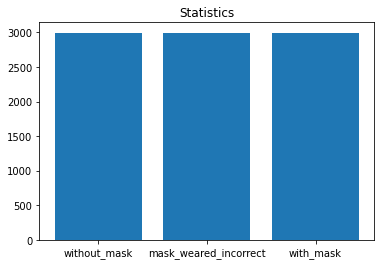

In [11]:
# Plot count of each ouput label
import matplotlib.pyplot as plt

count=[]
for label in output_classes:
  this_path=path+label
  dir=pathlib.Path(this_path)
  im_count=os.listdir(dir)
  count.append(len(im_count))

print(count)

plt.bar(output_classes,count)
plt.title("Statistics")
plt.show()

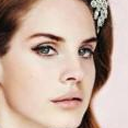

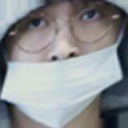

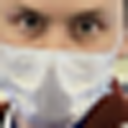

In [12]:
# Check some sample images (Use of cv2)
import cv2
from google.colab.patches import cv2_imshow

for label in output_classes:
  this_path=path+label
  dir=pathlib.Path(this_path)
  im_count=os.listdir(dir)
  img_path = this_path + '/' + im_count[1]
  img = cv2.imread(img_path)
  cv2_imshow(img)

In [13]:
print(img.shape)

(128, 128, 3)


In [14]:
first = None
img_path_first = None
img_first = None
first_shape = None
flag = 1
f = 1

for label in output_classes:
  this_path=path+label
  dir=pathlib.Path(this_path)
  im_count = os.listdir(dir)
  if flag == 1:
    first = im_count[0];
    img_path_first = this_path + '/' + first
    img_first = cv2.imread(img_path_first)
    first_shape = img_first.shape
    flag = 0
  for i in im_count:
    img_path = this_path + '/' + i
    img = cv2.imread(img_path)
    if img.shape != first_shape:
      print("img sizes not equal")
      f = 0
if f == 1:
  print("img sizes are equal")


    

img sizes are equal


In [15]:
# If the shape is variable, reshape to a common size 
# If it is same, prove it
# done above
print(first_shape)

(128, 128, 3)


In [16]:
# Anything else you want to plot/experiment

### Model Definition
Choose a model for Transfer Learning (You may also experment with multiple models and keep all of them in this notebook)

In [17]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential

In [18]:
# Choose and define base model
# VGG16 is a winner of imagenet compitition in 2014. So, we are going to use the same weights used to train actual VGG16 Image Classification model from that compitition
# we will be using VGG16 architecture. We will pass the three parameters, that are input size of an image, weights="imagenet" and include_top=Flase
#include_top is false because we don't need to import whole architecture. 
# We need only the Convolutional architecture of VGG16. After that we will add our layer and which will be trained according to our dataset.
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

vgg16 = VGG16(input_shape=first_shape, weights='imagenet', include_top=False)

In [19]:
# Print base model summary and have a look at the layers
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [20]:
# As we're using Transfer Learning, you do not need to train all the layers. Freeze all of the layers or train some layers (experiment)
for layer in vgg16.layers:
    layer.trainable = False
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [21]:
# Append Fully connected/custom Conv2D/Dropout/MaxPooling layers to the base model
flatten = Flatten()(vgg16.output)
dense_1 = Dense(units=500, activation='relu')(flatten)
dense_2 = Dense(units=500, activation='relu')(dense_1)
dense_3 = Dense(units=100, activation='relu')(dense_2)
dense_4 = Dense(units=100, activation='relu')(dense_3)


In [22]:
# Add the final output layer
dense_output = Dense(units=1, activation='sigmoid')(dense_4)

In [23]:
# Print your model's summary
model = Model(inputs=vgg16.input, outputs=dense_output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [24]:
# Compile you model (set the parameters like loss/optimizers/metrics)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

### Data Augmentation and Pre-processing
Augment the data. You may also try dyanamic augmentation using [`tf.keras.preprocessing.image.ImageDataGenerator `](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).   
You may use [`tf.keras.applications.vgg16.preprocess_input`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input)(or some other base model's utility) for pre-processing (can also be passed as a parameter to `ImageDataGenerator`)

In [25]:
from keras.applications.vgg16 import preprocess_input # Change according to your base model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(rescale=1./255, validation_split=0.2,rotation_range=20,zoom_range=0.05,width_shift_range=0.05,)
# Your code 

In [26]:
# Anything else you wish to try

### Training and Validation Dataset  
Split the dataset into training and validation (We'll be looking for your validation accuracy, assume we are using complete dataset for now). 

Hint: `flow_from_directory` used with `ImageDataGenerator` will simplify things for you.

In [27]:
# Your code
training_dataset = aug.flow_from_directory(batch_size=32,directory=path,target_size=(128, 128),subset="training",class_mode='categorical')
test_dataset = aug.flow_from_directory(batch_size=32,directory=path,target_size=(128,128),subset="validation",class_mode='categorical')

Found 7188 images belonging to 3 classes.
Found 1794 images belonging to 3 classes.


### Training  
Train your model for some epochs and plot the graph. Try and save your best model. Experiment with the parameters of `model.fit`

In [ ]:
from keras.callbacks import ModelCheckpoint
# ModelCheckpoint is helpful to save the model giving best results (brownie points)
r = model.fit(
  training_dataset,
  validation_data=test_dataset,
  epochs=10,
  steps_per_epoch=len(training_dataset),
  validation_steps=len(test_dataset)
)


Epoch 1/10
 97/225 [===========>..................] - ETA: 11:58 - loss: 0.6467 - accuracy: 0.6617

### Evaluate the performance

In [ ]:
# Plot training & validation loss/accuracy values
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']

loss = r.history['loss']
val_loss = r.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# print classification report
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
validation_classes = []
validation_images = []
for i in range( -(-test_dataset.samples // test_dataset.batch_size)):
        batch = test_dataset.next()
        expected = np.argmax(batch[1], axis=1)
        validation_classes.extend(expected)
        validation_images.extend(batch[0])
validation_classes = np.array(validation_classes)
validation_images = np.array(validation_images)
Y_pred = model.predict(validation_images)
y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(validation_classes, y_pred,target_names = ['without_mask', 'mask_weared_incorrect', 'with_mask']))